# ТЗ_Бизнес-аналитик_Ощепкова  

## Задание:  

Требуется провести анализ изменения цены лечения в 2022 году относительно 2021 года в медицинской клинике и определить ключевые драйверы изменения цены лечения.  

**Проверка гипотез:**  

- Средняя стоимость лечения изменилась.  
- Средняя стоимость лечения пациентов изменилась из-за поло-возрастной структуры обслуживаемых пациентов.    
- Средняя стоимость лечения пациентов изменилась из-за соотношения дешевых и дорогих услуг.

## Обзор данных  

Ознакомимся с входными данными

In [134]:
# импортируем библиотеки

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns  
from scipy import stats as st
import math as mth
from datetime import timedelta

In [135]:
# игнорируем предупреждения

import warnings
warnings.filterwarnings('ignore') 

# снимем ограничения на вывод строк и столбцов

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ограничим вывод цифр после точки для float

pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [136]:
# прочитаем файл с данными и сохраним его в переменную

data = pd.read_excel(r"C:\Users\osenk\Downloads\data_test_task_2022.xlsx", parse_dates=['service_date'])
data.head()

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.00,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое иссл...",284,1,490777,2.00,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,2.00,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.00,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.00,26


In [137]:
# получим общую информацию о таблице

data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   record_id             85369 non-null  int64         
 1   service_date          85369 non-null  datetime64[ns]
 2   service_name          85369 non-null  object        
 3   service_amount        85369 non-null  int64         
 4   service_number        85369 non-null  int64         
 5   insured               85369 non-null  int64         
 6   sex_id                85348 non-null  float64       
 7   age_for_service_date  85369 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 5.2+ MB


**Описание данных:**

- record_id- уникальный идентификатор строки данных
- service_date - дата оказания медицинской услуги
- service_name - наименование медицинской услуги
- service_number - количество услуг
- service_amount - сумма выплат (стоимость оказанных услуг в рублях)
- insured - уникальный идентификатор пациента
- sex_id - пол пациента (будем считать, что 1 - мужчины, 2 - женщины)
- age_for_service_date - возраст пациента

Все данные взяты из одной клиники.  

**Определения:**  

*Медицинский кейс* - последовательность медицинских услуг, полученных одним застрахованном в одной клинике с интервалом между любыми соседними по дате услугами не более 14 дней. Т.е. между любыми 2-мя услугами в кейсе не должно быть разрыва более 14 дней.

*Визит* - уникальное сочетание даты оказания услуги, застрахованного. Т.е. один визит - это один день, в который застрахованный побывал в клинике. Если был в одной клинике 2 раза, но в разные дни, то это два визита. Если получал услуги (в любом количестве) в одной клинике в один день, то это один визит.

### Вывод:  

Исходные данные - это таблица с записями о пациенте (уникальный номер пациента, пол, возраст) и оказанных ему клиникой услуг (название услуги, цена услуги, кол-во услуг и дата предоставления услуги).  

В поле "sex_id"(пол пациента) есть незначительное кол-во пропусков значений - менее 1%. При анализе их можно отбросить, это не повлияет на результат исследования.

## Предобработка данных

- **Изменим тип данных:** пропущенные значения в столбце sex_id заменим на "3" - пол не определен.

In [138]:
# посмотрим на уникальные значения столбца sex_id

data['sex_id'].unique()

array([ 2.,  1., nan])

In [139]:
# заменим nan-значения в столбце sex_id на 3

data['sex_id'] = data['sex_id'].fillna(3)

# изменим тип данных столбца sex_id с float на int

data['sex_id'] = data['sex_id'].astype(int)

- **Проверим корректность значений:** нет ли в числовых данных отрицательных значений

In [140]:
unique_colomns = data[['service_amount', 'service_number', 'age_for_service_date', 'insured', 'record_id']]

#создаем цикл, который выведет уникальные значения по столбцам
for col in unique_colomns: 
    print(col, ': ', data[col].min())
    print()

service_amount :  147

service_number :  1

age_for_service_date :  0

insured :  125073

record_id :  30268157003



- **Проверим наличие дубликатов**

In [141]:
# найдем сумму явных дубликатов в таблице

data.duplicated().sum()

0

- **Разделим таблицу на две по годам 2021 и 2022**

In [142]:
# добавим отдельно столбецы с годом и месяцем

data['year_date'] = pd.to_datetime(data['service_date']).dt.year
data['month_date'] = pd.to_datetime(data['service_date']).dt.month

# разделим таблицу

data_2021 = data.loc[data.loc[:, 'year_date'] == 2021]
data_2022 = data.loc[data.loc[:, 'year_date'] == 2022]

In [143]:
# посмотрим, за какое время предоставленны данные

print('2021 год')
print(data_2021['service_date'].min())
print(data_2021['service_date'].max())
print()
print('2022 год')
print(data_2022['service_date'].min())
print(data_2022['service_date'].max())

2021 год
2021-01-03 00:00:00
2021-12-31 00:00:00

2022 год
2022-01-03 00:00:00
2022-08-31 00:00:00


In [144]:
# проверим разделение и выведем кол-во строк каждой таблицы

display(data_2021.head())
print(data_2021.shape[0])
display(data_2022.head())
print(data_2022.shape[0])

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,year_date,month_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2,26,2021,1
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое иссл...",284,1,490777,2,26,2021,1
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,2,26,2021,1
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2,26,2021,1
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2,26,2021,1


44392


,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,year_date,month_date
44392,31996230303,2022-01-11,Магнитотерапия (1 сеанс),1090,1,625892,1,33,2022,1
44393,31996230403,2022-01-11,СМТ-форез (1 сеанс) (2 поля),950,1,625892,1,33,2022,1
44394,31996230503,2022-01-18,"Прием невролога, повторный",1380,1,625892,1,33,2022,1
44395,31996230603,2022-01-18,Магнитотерапия (1 сеанс),1090,1,625892,1,33,2022,1
44396,31996230703,2022-01-18,"Прием физиотерапевта, повторный",1380,1,625892,1,33,2022,1


40977


### Вывод:  

Данные предоставлены с 3 января по 31 декабря для 2021 года и с 3 января по 31 августа для 2022 года.

Пропуски в поле "sex_id"(пол пациента) заменили на "3", что будет означать - пол не определен, чтобы изменить тип данных на целое число.  

Данные в таблице корректны: отрицательных значений нет, дубликатов нет.

За 2021 год информации больше на 4 месяца. При этом кол-во строк за 2022 год меньше всего на 8%, что говорит о том, что кол-во оказанных услуг в 2022 году увеличилось.

## Исследовательский анализ данных

### 1. Посмотрим на распределение данных в столбце service_amount (стоимость услуг)

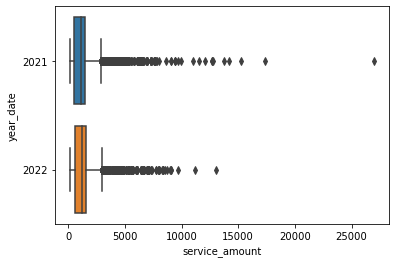

In [145]:
# выведем диаграмму распределения "ящик с усами" для service_amount

sns.boxplot(x='service_amount', y='year_date', data=data, orient='h');

In [146]:
# выведем список характерных статистических показателей и округлим

print('2021 год')
print(data_2021['service_amount'].describe().round())
print()
print('2022 год')
print(data_2022['service_amount'].describe().round())

2021 год
count   44392.00
mean     1139.00
std       816.00
min       147.00
25%       525.00
50%      1120.00
75%      1470.00
max     26999.00
Name: service_amount, dtype: float64

2022 год
count   40977.00
mean     1195.00
std       779.00
min       150.00
25%       600.00
50%      1200.00
75%      1540.00
max     13000.00
Name: service_amount, dtype: float64


Распределение значений в поле service_amount (стоимость оказанных услуг) для 2021 и 2022 годов идентичны, они сильно смещены влево, что говорит о большом кол-ве небольших сумм за услуги.  

Очень больших сумм не много и в основной массе они не "перевешивают" - среднее значение практически равно медиане. Но в дальшейшем выбросы могут исказить рассчеты. Поэтому посмотрим на 99 перцентиль и отбросим 1% выбросов, чтобы в дальнейшем использовать среднее значение без искажений.

In [147]:
# посчитаем 99 перцентиль

print(np.percentile(data_2021['service_amount'], [99]))
print(np.percentile(data_2022['service_amount'], [99]))

[3780.]
[3906.8]


In [148]:
# перезапишем таблицы для 2021 и 2022 годов

data_2021 = data_2021.loc[data_2021.loc[:, 'service_amount'] <= 4000]
data_2022 = data_2022.loc[data_2022.loc[:, 'service_amount'] <= 4000]

### 2. Сформулируем основные показатели, описывающие стоимость лечения, относительно которых будет формулироваться гипотезы. 

Для формулировки гипотез об изменении стоимости лечения будем использовать показатели:

- **средняя стоимость визита:** среднее значение стоимости всех услуг, входящих в один визит для одного пациента
- **средняя стоимость медицинского кейса:** среднее значение стоимости медицинского кейса для одного пациента


## Проверка гипотез

### Посмотрим на распределение сумм за услуги по месяцам

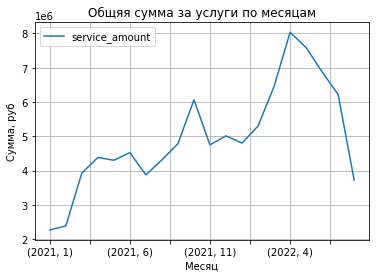

In [149]:
# построим графики сумм за услуги по месяцам за оба года

data.pivot_table(index=['year_date', 'month_date'], values='service_amount', aggfunc='sum').plot()
plt.title('Общяя сумма за услуги по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма, руб')
plt.grid()
plt.show();

Изменение суммы стоимости услуг может зависеть от изменения стоимости лечения.

На изменение стоимости лечения может повлиять: 
 
- изменение средней стоимости визита
- изменение средней стоимости медицинского кейса
- изменение стоимости услуг (непосредственно самих цен на услуги)
- изменение доли дешевых/дорогих услуг относительно всего кол-ва услуг

### 1. Рассчитаем основные показатели

 #### 1.1 Для средней стоимости визита

In [150]:
# сгруппируем таблицы за 2021 и 2022 года по визитам и посчитаем сумму услуг за один визит для каждого пациента

data_groupby_visits_2021 = data_2021.groupby(['service_date', 'insured']).agg({'service_number':'sum', 'service_amount':'sum'})
data_groupby_visits_2022 = data_2022.groupby(['service_date', 'insured']).agg({'service_number':'sum', 'service_amount':'sum'})

# выведем показатели кол-ва строк и среднего значения

print('2021 год')
print('Кол-во строк:', data_groupby_visits_2021.shape[0])
print('Среднее значение стоимости услуг:', data_groupby_visits_2021['service_amount'].mean())
print('Среднее значение кол-ва услуг:', data_groupby_visits_2021['service_number'].mean())
print()
print('2022 год')
print('Кол-во строк:', data_groupby_visits_2022.shape[0])
print('Среднее значение стоимости услуг:', data_groupby_visits_2022['service_amount'].mean())
print('Среднее значение кол-ва услуг:', data_groupby_visits_2022['service_number'].mean())

2021 год
Кол-во строк: 15786
Среднее значение стоимости услуг: 3078.8959204358293
Среднее значение кол-ва услуг: 2.854111237805651

2022 год
Кол-во строк: 14400
Среднее значение стоимости услуг: 3310.683472222222
Среднее значение кол-ва услуг: 2.883888888888889


 #### 1.2 Для средней стоимости медицинского кейса

In [151]:
# сгруппируем таблицу по клиентам и датам посещения клиники в 2021 году

data_groupby_case_2021 = data_2021.groupby(['insured', 'service_date']).agg({'service_number':'sum', 'service_amount':'sum'}).reset_index()
data_groupby_case_2021 = data_groupby_case_2021.sort_values(['insured', 'service_date'],ascending = True)

data_groupby_case_2021.head(10)

,insured,service_date,service_number,service_amount
0,125073,2021-01-11,3,2321
1,125073,2021-01-16,1,1827
2,125073,2021-01-17,2,3813
3,125073,2021-01-23,1,1313
4,125073,2021-09-21,2,2940
5,125073,2021-09-25,5,4023
6,125073,2021-09-28,1,1313
7,125073,2021-09-30,1,1470
8,125073,2021-10-02,3,5120
9,125073,2021-10-05,1,1380


In [152]:
# составим списки со стоимостью и кол-вом услуг всех медицинских кейсов за 2021 год

my_list_amount_2021 = []
my_list_number_2021 = []

for i in range(data_groupby_case_2021.shape[0]):
    if i == 0:
        my_list_amount_2021.append(data_groupby_case_2021.iloc[i]['service_amount'])
        my_list_number_2021.append(data_groupby_case_2021.iloc[i]['service_number'])
    elif (data_groupby_case_2021.iloc[i]['insured'] == data_groupby_case_2021.iloc[i-1]['insured']) and ((data_groupby_case_2021.iloc[i]['service_date'] - data_groupby_case_2021.iloc[i-1]['service_date']) <= timedelta(days=14)):
        my_list_amount_2021[-1] += data_groupby_case_2021.iloc[i]['service_amount']
        my_list_number_2021[-1] += data_groupby_case_2021.iloc[i]['service_number']
    else:
        my_list_amount_2021.append(data_groupby_case_2021.iloc[i]['service_amount'])
        my_list_number_2021.append(data_groupby_case_2021.iloc[i]['service_number'])  

In [153]:
# сгруппируем таблицу по клиентам и датам посещения клиники в 2022 году

data_groupby_case_2022 = data_2022.groupby(['insured', 'service_date']).agg({'service_number':'sum', 'service_amount':'sum'}).reset_index()
data_groupby_case_2022 = data_groupby_case_2022.sort_values(['insured', 'service_date'],ascending = True)

data_groupby_case_2022.head(10)

,insured,service_date,service_number,service_amount
0,125094,2022-04-06,4,2910
1,125094,2022-04-13,2,3470
2,142438,2022-01-09,1,1540
3,142438,2022-01-15,2,900
4,142438,2022-01-16,2,3300
5,142438,2022-01-18,5,2890
6,142447,2022-01-05,5,3570
7,142447,2022-01-07,1,1380
8,142447,2022-02-03,2,2220
9,142447,2022-02-05,2,900


In [154]:
# составим списки со стоимостью и кол-вом услуг всех медицинских кейсов за 2022 год

my_list_amount_2022 = []
my_list_number_2022 = []

for i in range(data_groupby_case_2022.shape[0]):
    if i == 0:
        my_list_amount_2022.append(data_groupby_case_2022.iloc[i]['service_amount'])
        my_list_number_2022.append(data_groupby_case_2022.iloc[i]['service_number'])
    elif (data_groupby_case_2022.iloc[i]['insured'] == data_groupby_case_2022.iloc[i-1]['insured']) and ((data_groupby_case_2022.iloc[i]['service_date'] - data_groupby_case_2022.iloc[i-1]['service_date']) <= timedelta(days=14)):
        my_list_amount_2022[-1] += data_groupby_case_2022.iloc[i]['service_amount']
        my_list_number_2022[-1] += data_groupby_case_2022.iloc[i]['service_number']
    else:
        my_list_amount_2022.append(data_groupby_case_2022.iloc[i]['service_amount'])
        my_list_number_2022.append(data_groupby_case_2022.iloc[i]['service_number'])  

In [155]:
print('2021 год')
print('Кол-во строк:', len(my_list_amount_2021))
print('Среднее значение стоимости кейса:', sum(my_list_amount_2021)/len(my_list_amount_2021))
print('Среднее значение кол-ва услуг в кейсе:', sum(my_list_number_2021)/len(my_list_number_2021))
print()
print('2022 год')
print('Кол-во строк:', len(my_list_amount_2022))
print('Среднее значение стоимости кейса:', sum(my_list_amount_2022)/len(my_list_amount_2022))
print('Среднее значение кол-ва услуг в кейсе:', sum(my_list_number_2022)/len(my_list_number_2022))

2021 год
Кол-во строк: 4683
Среднее значение стоимости кейса: 10378.699765107836
Среднее значение кол-ва услуг в кейсе: 9.620969464018792

2022 год
Кол-во строк: 4328
Среднее значение стоимости кейса: 11015.21303142329
Среднее значение кол-ва услуг в кейсе: 9.595194085027726


### 2. Проверка гипотезы: средняя стоимость лечения изменилась

**На основе стоимости визита**

*Нулевая гипотеза:* Среднее значение стоимости услуг за один визит не изменилось.  
*Альтернативная гипотеза:* Среднее значение стоимости услуг за один визит изменилось.

Проверка гипотезы: проведем t-тест для двух независимых выборок.  
Выборки по размеру разные, поэтому параметр equal_var - False.
Уровень статистической значимости зададим в 5%.

In [156]:
# проводим т-тест

results = st.ttest_ind (data_groupby_visits_2021['service_amount'], data_groupby_visits_2022['service_amount'], equal_var=False)
print('{:0.14f}'.format(results.pvalue))

0.00000000000001


Получаем p-value близкое к нулю, следовательно данные опровергают нулевую гипотезу.  
Принимаем альтернативную гипотезу - среднее значение стоимости услуг за один визит изменилось. 

Первая гипотеза исследования подтверждена.
Исходя из расчетов среднего значения, можем утверждать, что стоимость лечения для 2022 года выросла по сравнению со стоимостью лечения в 2021 году на **7%**.

**На основе стоимости медицинского кейса**  

*Нулевая гипотеза:* Среднее значение стоимости услуг за один визит не изменилось.  
*Альтернативная гипотеза:* Среднее значение стоимости услуг за один визит изменилось.

Проверка гипотезы: проведем t-тест для двух независимых выборок.
Выборки по размеру разные, поэтому параметр equal_var - False. Уровень статистической значимости зададим в 5%.

In [157]:
# проводим т-тест

results = st.ttest_ind (my_list_amount_2021, my_list_amount_2022, equal_var=False)
print('{:0.14f}'.format(results.pvalue))

0.04593549170698


Получаем p-value очень близкое к уровню статистической значимости. Данные скорее подтверждают нулевую гипотезу: среднее значение стоимости медицинского кейса не изменилось.

Если исходить из расчетов среднего значения медицинского кейса, можем предположить, что стоимость лечения для 2022 года не изменилась по сравнению со стоимостью лечения в 2021 году и цены на услуги не выросли.

### 4. Проверка гипотезы для стоимости визита: средняя стоимость обслуживания пациентов изменилась из-за изменения поло-возрастной структуры обслуживаемых пациентов.  

Посмотрим на распределение пациентов по возрасту и посчиатем кол-во мужчин и женщин.

In [158]:
# выведем список характерных статистических показателей и округлим

print('2021 год')
print(data_2021['age_for_service_date'].describe().round())
print()
print('2022 год')
print(data_2022['age_for_service_date'].describe().round())

2021 год
count   44044.00
mean       33.00
std        12.00
min         0.00
25%        27.00
50%        34.00
75%        41.00
max        83.00
Name: age_for_service_date, dtype: float64

2022 год
count   40731.00
mean       34.00
std        12.00
min         0.00
25%        27.00
50%        34.00
75%        41.00
max        75.00
Name: age_for_service_date, dtype: float64


In [159]:
# уберем значения, где пол не определен

data_2021 = data_2021.loc[data_2021.loc[:, 'sex_id'] != 3]

# сгуппируем таблицы по полу

data_sex_groupby_2021 = data_2021.groupby(['sex_id']).agg({'sex_id':'count','service_number':'sum', 'service_amount':'sum'})
data_sex_groupby_2022 = data_2022.groupby(['sex_id']).agg({'sex_id':'count','service_number':'sum', 'service_amount':'sum'})

# посчитаем процент мужчин и женщин от общего кол-ва пациентов

data_sex_groupby_2021['sex_percent'] = data_sex_groupby_2021['sex_id']/data_2021.shape[0]*100
data_sex_groupby_2022['sex_percent'] = data_sex_groupby_2022['sex_id']/data_2022.shape[0]*100

display(data_sex_groupby_2021)
display(data_sex_groupby_2022)    

,sex_id,service_number,service_amount,sex_percent
sex_id,,,,
1,17225,17499,19211083,39.13
2,26798,27535,29370453,60.87


,sex_id,service_number,service_amount,sex_percent
sex_id,,,,
1,15102,15266,17625847,37.08
2,25629,26262,30047995,62.92


Распределение по возрасту идентично.  
Доли мужчин и женщин от общего кол-ва пациентов отличаются примерно на 2%.  В 2022 году доля мужчин сократилась, а доля женщин выросла.

**Проверим гипотезу, что доля женщин от общего кол-ва пациентов за 2021 и 2022 года изменилась.**
 
*Нулевая гипотеза:* Доли женщин от общего кол-ва пациентов для 2021 и 2022 года равны.    
*Альтернативная гипотеза:* Доли женщин от общего кол-ва пациентов для 2021 и 2022 года не равны.  

Проверка гипотезы: посчитаем доли на калькуляторе Evan's Awesome A/B Tools .  
Уровень статистической значимости зададим в 5%.

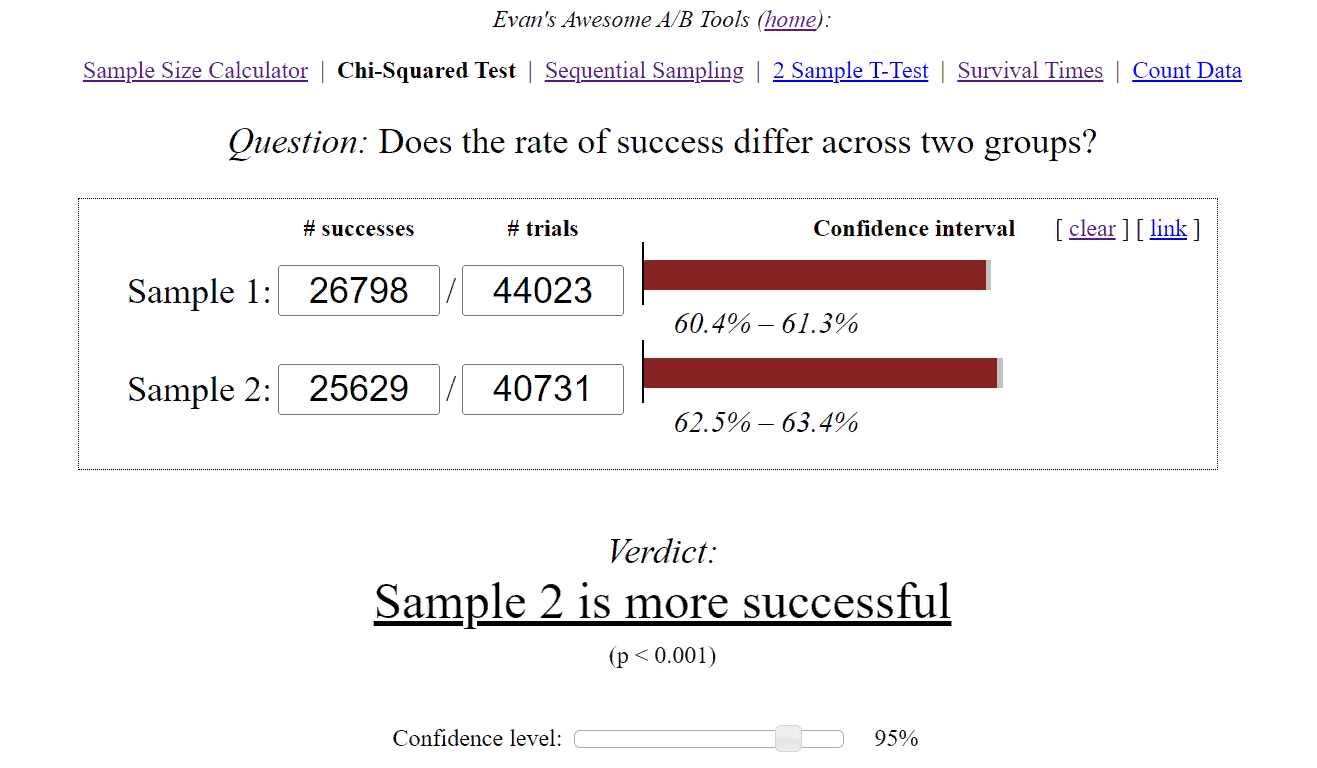

In [160]:
Image(filename = r"C:\Users\osenk\Downloads\Screenshot.png")

Расчеты показывают p-value меньше уровня статистической значимости, а также доверительные интервалы двух групп не пересекаются. Можем предположить, что доля женщин действительно увеличилась и могла повлиять на стоимость лечения в 2022 году по сравнению с 2021 годом.  

Возможно, женщины применяют большее кол-во услуг за один визит.

- **Сравним кол-во используемых услуг женщинами за один визит в 2021 и 2022 годах**

In [161]:
# для женщин 2021 год

data_woman_2021 = data_2021.loc[data_2021.loc[:,'sex_id'] == 2]
data_woman_2021 = data_woman_2021.groupby(['service_date', 'insured']).agg({'service_number':'sum'})

# для женщин 2022 год

data_woman_2022 = data_2022.loc[data_2022.loc[:,'sex_id'] == 2]
data_woman_2022 = data_woman_2022.groupby(['service_date', 'insured']).agg({'service_number':'sum'})

print('2021 год')
print('Среднее значение:', data_woman_2021['service_number'].mean())
print()
print('2022 год')
print('Среднее значение:', data_woman_2022['service_number'].mean())

2021 год
Среднее значение: 2.9398889600683322

2022 год
Среднее значение: 2.9507865168539325


In [162]:
# проводим т-тест

results = st.ttest_ind (data_woman_2021['service_number'], data_woman_2022['service_number'], equal_var=False)
print('{:0.14f}'.format(results.pvalue))

0.80504106984909


Кол-во услуг применяемых женщинами за один визит не изменилось. Поэтому мы не можем утверждать, что средняя стоимость обслуживания пациентов изменилась из-за изменения поло-возрастной структуры обслуживаемых пациентов.  
Отвергаем эту гипотезу.


### 5. Проверка гипотезы для стоимости визита: средняя стоимость обслуживания изменилась из-за изменения соотношения дешевых и дорогих услуг.  

*Дешевые услуги* - услуги до 2000 руб.  
*Дорогие услуги* - услуги более 2000 руб.  

Рассмотрим распределение услуг за 2021 и 2022 года. 

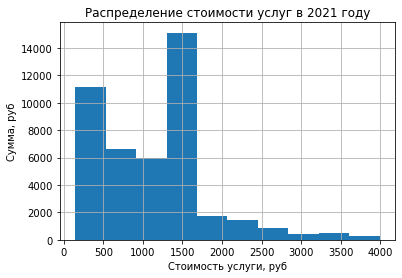

In [163]:
# построим гистограмму для стоимости услуг в 2021 году

data_2021['service_amount'].hist()
plt.title('Распределение стоимости услуг в 2021 году')
plt.xlabel('Стоимость услуги, руб')
plt.ylabel('Сумма, руб')
plt.show();

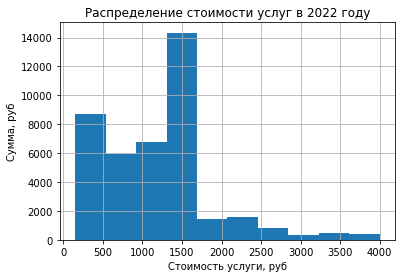

In [164]:
# построим гистограмму для стоимости услуг в 2022 году

data_2022['service_amount'].hist()
plt.title('Распределение стоимости услуг в 2022 году')
plt.xlabel('Стоимость услуги, руб')
plt.ylabel('Сумма, руб')
plt.show();

Основную часть используемых услуг составляют услуги стоимостью до 2000 руб.  
Рассчитаем долю дорогих услуг от общего кол-ва для 2021 и 2022 годов.  

In [165]:
# посчитаем долю дорогих услуг от общего кол-ва для 2021 и 2022 годов

print('Доля дорогих услуг 2021:', data_2021.loc[data_2021.loc[:,'service_amount'] >= 2000]['service_amount'].count()/data_2021['service_amount'].count()*100)
print('Доля дорогих услуг 2022:', data_2022.loc[data_2022.loc[:,'service_amount'] >= 2000]['service_amount'].count()/data_2022['service_amount'].count()*100)


Доля дорогих услуг 2021: 7.943574949458237
Доля дорогих услуг 2022: 8.956323193636297


**Проверим гипотезу, что доля дорогих услуг за 2021 и 2022 года изменилась.**

*Нулевая гипотеза:* Доли дорогих услуг от общего кол-ва услуг для 2021 и 2022 года равны.  
*Альтернативная гипотеза:* Доли дорогих услуг от общего кол-ва услуг для 2021 и 2022 года равны.

Проверка гипотезы: посчитаем доли на калькуляторе Evan's Awesome A/B Tools .
Уровень статистической значимости зададим в 5%.

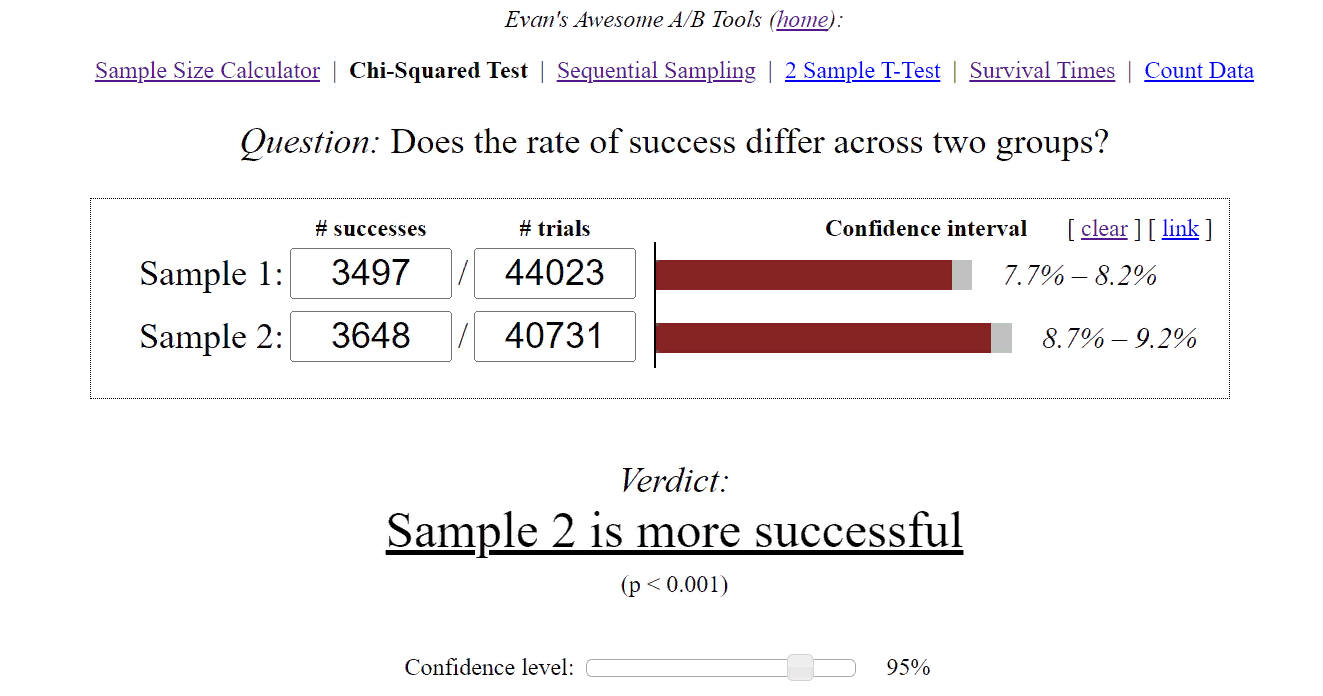

In [166]:
Image(filename = r"C:\Users\osenk\Downloads\Screenshot (1).png")

Расчеты показывают p-value меньше уровня статистической значимости, а также доверительные интервалы двух групп не пересекаются. Можем предположить, что доля дорогих услуг действительно увеличилась и могла повлиять на стоимость лечения в 2022 году по сравнению с 2021 годом.
Принимаем альтернативную гипотезу.

## Итоги исследования  

Прежде чем исследовать данные, мы ознакомились с ними, проверили их корректность.

Определили что средняя стоимость лечения за 2022 год изменилась по сравнению с 2021 годом. За стоимость лечения мы принимаем стоимость одного визита для одного пациента.  
Согласно получинным данным, **стоимость лечения увеличилась на 7%**.

Проверили проверку гипотез:  
- Отвергли гипотезу о том, что средняя стоимость лечения пациентов изменилась из-за поло-возрастной структуры обслуживаемых пациентов.
- Приняли гипотезу о том, что средняя стоимость лечения пациентов изменилась из-за соотношения дешевых и дорогих услуг.

Таким образом, можно предположить, что **ключевым драйвером для изменения стоимости лечения стало увеличение доли дорогих услуг (стоимостью более 2000 руб.) от общего кол-ва услуг**.